In [1]:
%load_ext autoreload
%autoreload 2    

In [2]:
import os
import numpy as np
import glob
import PIL.Image as Image

# pip install torchsummary
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import models
from torchsummary import summary
import torch.optim as optim
from time import time
import pandas as pd 
import matplotlib.pyplot as plt
from IPython.display import clear_output
import cv2
import torchmetrics

import albumentations as A
from albumentations.pytorch import ToTensorV2
plt.rcParams['figure.figsize'] = [12.5, 5]

In [3]:
import numpy as np
# ! pip install opencv-python==4.5.5.64
import cv2 

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [5]:
batch_size = 8

# Custom loss

In [6]:
#PyTorch
ALPHA = 0.8
GAMMA = 2

class FocalLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(FocalLoss, self).__init__()

    def forward(self, inputs, targets, alpha=ALPHA, gamma=GAMMA, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer    
        inputs = F.sigmoid(inputs)
        #first compute binary cross-entropy 
        BCE = F.binary_cross_entropy(inputs.to(float), targets.to(float), reduction='mean')
        BCE_EXP = torch.exp(-BCE)
        focal_loss = alpha * (1-BCE_EXP)**gamma * BCE
                       
        return focal_loss

# Augmentation

In [7]:
from data_loader import PH2, DRIVE

# Model

In [8]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Conv2d(3, 64, 3, padding=1)
        self.enc_conv1 = nn.Conv2d(64, 64, 3, padding=1)
        self.enc_conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.enc_conv3 = nn.Conv2d(64, 1, 3, padding=1)
        
    def forward(self, x):
        # encoder
        e0 = F.relu(self.enc_conv0(x))
        e1 = F.relu(self.enc_conv1(e0))
        e2 = F.relu(self.enc_conv2(e1))

        # no activation
        e3 = self.enc_conv3(e2)
        
        return e3

# Train

In [9]:
import torch
from torchmetrics import Metric

class Sensitivity(torchmetrics.Metric):
    def __init__(self, dist_sync_on_step=False):
        super().__init__(dist_sync_on_step=dist_sync_on_step)
        self.add_state("tp", default=torch.tensor(0), dist_reduce_fx="sum")
        self.add_state("fn", default=torch.tensor(0), dist_reduce_fx="sum")

    def update(self, preds: torch.Tensor, target: torch.Tensor):
        # Convert predictions to binary values (0 or 1)
        preds = torch.round(preds)

        # Calculate true positives and false negatives
        tp = torch.sum((preds >= 0.5) & (target == 1))
        fn = torch.sum((preds < 0.5) & (target == 1))

        # Update state variables
        self.tp += tp
        self.fn += fn

    def compute(self):
        # Calculate sensitivity/recall
        sensitivity = self.tp.float() / (self.tp + self.fn + 1e-12)

        return sensitivity


In [10]:
def train(model, opt, loss_fn, epochs, train_loader, val_loader, test_loader):
    X_test, Y_test = next(iter(test_loader))
    train_loss = []
    val_loss = []


    metric_dict = {
                'train_dice': torchmetrics.Dice().to(device),
                'train_iou': torchmetrics.JaccardIndex('binary').to(device),
                'train_acc': torchmetrics.Accuracy('binary').to(device),
                'train_sens': Sensitivity().to(device),
                'train_spec': torchmetrics.Specificity('binary').to(device),
                
                'val_dice': torchmetrics.Dice().to(device),
                'val_iou': torchmetrics.JaccardIndex('binary').to(device),
                'val_acc': torchmetrics.Accuracy('binary').to(device),
                'val_sens': Sensitivity().to(device),
                'val_spec': torchmetrics.Specificity('binary').to(device),

                                
                'test_dice': torchmetrics.Dice().to(device),
                'test_iou': torchmetrics.JaccardIndex('binary').to(device),
                'test_acc': torchmetrics.Accuracy('binary').to(device),
                'test_sens': Sensitivity().to(device),
                'test_spec': torchmetrics.Specificity('binary').to(device),
               }

    out_dict = {
                
                'train_loss':[],
                'train_dice': [],
                'train_iou': [],
                'train_acc': [],
                'train_sens': [],
                'train_spec': [],

                'val_loss':[],
                'val_dice': [],
                'val_iou':[],
                'val_acc': [],
                'val_sens': [],
                'val_spec': [],

                                
                'test_dice': [],
                'test_iou': [],
                'test_acc': [],
                'test_sens': [],
                'test_spec': [],
    }

    
    for epoch in range(epochs):
        tic = time()
        
        avg_loss = 0
        avg_loss_val = 0
        
        model.train()  # train mode
        for X_batch, Y_batch in train_loader:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            Y_pred = model(X_batch)
            Y_batch = Y_batch.unsqueeze(1)
            loss = loss_fn(Y_pred, Y_batch)  # forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate metrics to show the user
            avg_loss += loss / len(train_loader)

            metric_dict['train_dice'](F.sigmoid(Y_pred.flatten()), Y_batch.flatten().to(int))
            metric_dict['train_acc'](F.sigmoid(Y_pred.flatten()), Y_batch.flatten().to(int))
            metric_dict['train_iou'](F.sigmoid(Y_pred.flatten()), Y_batch.flatten().to(int))
            metric_dict['train_sens'](F.sigmoid(Y_pred.flatten()), Y_batch.flatten().to(int))
            metric_dict['train_spec'](F.sigmoid(Y_pred.flatten()), Y_batch.flatten().to(int))

            
        toc = time()

        model.eval()  # testing mode
        for X_batch, Y_batch in val_loader:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            
            Y_pred = model(X_batch)
            Y_batch = Y_batch.unsqueeze(1)
            loss_test = loss_fn(F.sigmoid(Y_pred), Y_batch)  # forward-pass
            avg_loss_val += loss / len(val_loader)

            metric_dict['val_dice'](F.sigmoid(Y_pred.flatten()), Y_batch.flatten().to(int))
            metric_dict['val_acc'](F.sigmoid(Y_pred.flatten()), Y_batch.flatten().to(int))
            metric_dict['val_iou'](F.sigmoid(Y_pred.flatten()), Y_batch.flatten().to(int))
            metric_dict['val_sens'](F.sigmoid(Y_pred.flatten()), Y_batch.flatten().to(int))
            metric_dict['val_spec'](F.sigmoid(Y_pred.flatten()), Y_batch.flatten().to(int))
            
        
        train_loss.append(avg_loss.detach().cpu())
        val_loss.append(avg_loss_val.detach().cpu())

        #plt.plot(train_loss, np.arange(len(train_loss)))
        #plt.plot(test_loss, np.arange(len(test_loss)))
                 
        for metric in ['dice', 'acc', 'iou', 'sens', 'spec']:
            out_dict['train_' + metric].append(metric_dict['train_' + metric].compute().detach().cpu())
            out_dict['val_' + metric].append(metric_dict['val_' + metric].compute().detach().cpu())

        
        
        print(f"Loss train: {avg_loss:.3f}\t Train dice: {metric_dict['train_dice'].compute():.3f}\t, Train IOU: {metric_dict['train_iou'].compute()}")

        Y_hat = (F.sigmoid(model(X_test.to(device))).detach().cpu() > 0.5) *1
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(X_test[k].numpy().astype(np.uint8), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(((Y_hat[k, 0] * 255).numpy().astype(np.uint8)), cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()
            
    model.eval()  # testing mode
    for X_batch, Y_batch in test_loader:
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)

        
        Y_pred = model(X_batch)
        Y_batch = Y_batch.unsqueeze(1)

        metric_dict['test_dice'](F.sigmoid(Y_pred.flatten()), Y_batch.flatten().to(int))
        metric_dict['test_acc'](F.sigmoid(Y_pred.flatten()), Y_batch.flatten().to(int))
        metric_dict['test_iou'](F.sigmoid(Y_pred.flatten()), Y_batch.flatten().to(int))
        metric_dict['test_sens'](F.sigmoid(Y_pred.flatten()), Y_batch.flatten().to(int))
        metric_dict['test_spec'](F.sigmoid(Y_pred.flatten()), Y_batch.flatten().to(int))

    
    for metric in ['dice', 'acc', 'iou', 'sens', 'spec']:
        out_dict['test_' + metric].append(metric_dict['test_' + metric].compute().detach().cpu())

    out_dict['train_loss'] = train_loss
    out_dict['val_loss'] = val_loss
    
    
    return out_dict, metric_dict


    
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [F.sigmoid(model(X_batch.to(device))) for X_batch, _ in data]
    return np.array(Y_pred)

# Other Dataset

In [11]:
size = 256
batch_size = 8

train_transform = A.Compose(
    [
        A.Resize(size, size),
        A.Rotate(limit=90, p=1, border_mode=cv2.BORDER_CONSTANT),
        #A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        #A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
        A.GaussNoise(p=0.5),
        A.Flip(p=0.5),
        A.Normalize(),
        ToTensorV2(),
        
    ]
)

test_transform = A.Compose([A.Resize(size, size), 
                            A.Normalize(),
                            ToTensorV2()])

In [12]:
trainset = DRIVE(train=True, transform=train_transform) # test_transform for no augment
# valset = PH2('val', transform=test_transform)
testset = DRIVE(train=False, transform=test_transform)

train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=8,)# persistent_workers=True, pin_memory=True)
# val_loader = DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=8,)# persistent_workers=True, pin_memory=True)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=8,)# persistent_workers=True, pin_memory=True)

In [13]:
def visualize_img_and_label():

    
    plt.figure(figsize=(10, 4))
    for i in range(5):
        im, lb = trainset.__getitem__(i)
        plt.subplot(2, 5, i+1)
        plt.imshow(im.permute(1,2,0))
        plt.xticks([])
        plt.yticks([])
        plt.subplot(2, 5, 6+i)
        plt.imshow(lb) # lab.permute(1,2,0)
        plt.xticks([])
        plt.yticks([])
        plt.subplots_adjust(hspace=0, wspace=0)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


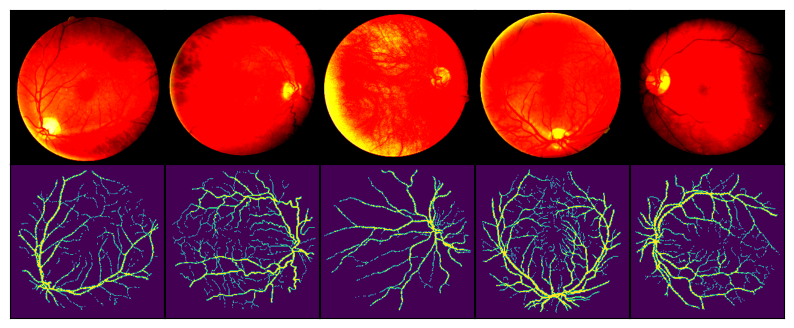

In [14]:


visualize_img_and_label()

In [15]:

class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        inputs = F.sigmoid(inputs.view(-1)).to(float)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        
        return dice_loss


In [16]:
import torch
import torch.nn as nn

class ClassWeightedBCELoss(nn.Module):
    def __init__(self, weight=None, reduction='mean'):
        super(ClassWeightedBCELoss, self).__init__()
        self.weight = weight
        self.reduction = reduction

    def forward(self, inputs, targets):
        loss = nn.functional.binary_cross_entropy(inputs, targets, weight=self.weight, reduction=self.reduction)
        return loss

In [17]:
model = SimpleCNN().to(device)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([10]).cuda())

TypeError: Invalid shape (3, 256, 256) for image data

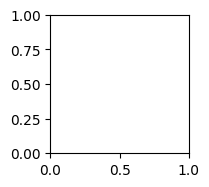

In [18]:
out_dict, metric_dict = train(model, optim.Adam(model.parameters(), 0.001), loss_fn, 200, train_loader, test_loader, test_loader)

In [ ]:
# out_dict

In [ ]:
im, lab = next(iter(test_loader))
out = model(im.cuda())
plt.imshow(F.sigmoid(out)[0].squeeze().detach().cpu() > 0.5)